In [171]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from scipy import signal
import os
import warnings
warnings.filterwarnings('ignore')

### To-Do
    1, improve the slope extraction method (moving slope)
    2, gm-Vd-> shape difference (first point)
    3, Width file reader

In [172]:
#paramter input area
#dId/dVg=mobility*Cox*(W/L)*Vds
chtype='p'
names=['Vg','Vd','Ig','Id','Is','absId','absIg']
period=51 #cycle period #half of the number in row 257-259
W=[11.34,9.2,22.32,7.46,4.16,3.2,9.5,4.58,9.71,8.93,7.54,9.38,17.1,9.48,7.74,13.23,7.26,13.47,11.69,8.86]#um
L=4 #um
Cox=float(3.9*8.854*1e-12/(90*1e-9)) #F/m^2 (per unit square)

### Key functions to help process the data

In [181]:
#Data Processing Function
def monotonicStack(nums, chtype):
    # to make sure the slope is always monotonic decreasing for p-type or
    # increasing for n-type
    stack = []
    for i in range(len(nums)):
        if not stack:
            stack.append(nums[i])
        if chtype == 'n' or 'N':
            if stack and stack[-1] > nums[i]:
                stack.append(nums[i])
        if chtype == 'p' or 'P':
            if stack and stack[-1] > nums[i]:
                stack.append(nums[i])
    return stack


def getslope(Ids,Vg):
    gm=[]
    xMax,yMax=0,0
    tempMax=0
    for i in range(1,len(Ids)):
        slope=(Ids[i]-Ids[i-1])/(Vg[i]-Vg[i-1])
        gm.append(abs(slope))
        if abs(slope)>tempMax:
            tempMax=abs(slope)
            xMax,yMax=Vg[i],Ids[i] 
    return tempMax,gm,(xMax,yMax)

def extractParameter(data,period,W,L,Vds,Cox,Vg_range,chtype):
    '''
    transconductance, mobility, subthreshold swing, Vth
    
    '''
    #data['Id_density']=(data.iloc[:,-2]*1000/(W*1e-3)) #mA/mm
    Vg=data.iloc[Vg_range:Vg_range+period,:1].T.values[0]
    Ids=data.iloc[Vg_range:Vg_range+period,-3].values #A
    VgIds=pd.DataFrame({'Ids':Ids,'Vg':Vg})
    #calculate gm
    gm=getslope(Ids,Vg)[1] #length is 50
    gm.append(0)##for p type this is not a big deal..but for n-type....damn
    VgIds['lg(gm)']=[np.log10(x*1e-3/(W*1e-3)) for x in gm] #mS/mm
    VgIds['gm']=[(x*1e-3/(W*1e-3)) for x in gm] #mS/mm
    #VgIds.plot.scatter(x='Vg',y='lg(gm)')
    #use montonic queue to store only monotonic decreaseing datafor p-type device
    Ids_monotone=monotonicStack(Ids,chtype)
    Vg_monotone=[]
    for current in Ids_monotone:
        Vg_monotone.append(VgIds.loc[VgIds['Ids']==current,'Vg'].iloc[0])
    VgIds_Monotone=pd.DataFrame({'Ids':Ids_monotone,'Vg':Vg_monotone})
    logIds_Monotone=np.log10(Ids_monotone)
    VgIds_Monotone['logIds']=logIds_Monotone
    #VgIds_Monotone.plot.scatter(x='Vg',y='logIds')
    ##################################
    #two slope
    Slope=getslope(Ids_monotone,Vg_monotone)
    logSlope=getslope(logIds_Monotone,Vg_monotone)
    ##################################
    mu=Slope[0]*L/(Cox*W*abs(Vds))*1e4 #cm^2/VS
    SS=1/(logSlope[0])*1000 #mV/decade #cm^2/VS
    #calculate Vth
    k=-Slope[0] #it should be negative
    x,y=Slope[2]
    Vth=(k*x-y)/k
    return mu,SS,Vth,VgIds,VgIds_Monotone

def IVPlot(data,VgIds,VgIds_Monotone,root,file):
    #initial setup for IV curve
    sns.set(font_scale = 2)
    sns.set_style('whitegrid')
    gmMax=VgIds['gm'].max()
    IdsMax=VgIds['Ids'].max()
    IdsMin=VgIds['Ids'].min()
    fig1,ax1=plt.subplots(ncols=2,figsize=(6,6))
    plt.subplots_adjust(left=0,right=3)
    ax1[0].autoscale(enable='True')
    sns.regplot(x='Vg',y='gm',data=VgIds,scatter_kws={"s": 180},fit_reg=False,ax=ax1[0])
    ax1[0].set_yscale('log')
    ax1[0].set_ylim(gmMax*0.0001,gmMax*10)
    ax1[0].set_title('{}-Transconductance'.format(file),fontsize=14)
    ax1[0].set_xlabel('Vg (V)',fontsize=18)
    ax1[0].set_ylabel('gm',fontsize=18)
    sns.regplot(x='Vg',y='Ids',data=VgIds_Monotone,scatter_kws={"s": 180},fit_reg=False,ax=ax1[1])
    ax1[1].set_title('{}-Monotonic Region'.format(file),fontsize=14)
    ax1[1].set_yscale('log')
    ax1[1].set_ylim(IdsMin*0.5,IdsMax*2)
    ax1[1].set_xlabel('Vg (V)',fontsize=18)
    ax1[1].set_ylabel('Ids (A)',fontsize=18)
    ############################################################################################################################

    fig,ax=plt.subplots(ncols=2,figsize=(6,6))
    plt.subplots_adjust(left=0,right=3)
    lowVds=data.iloc[:2*period,:]
    lowVds_upperbound=data.iloc[:2*period,-1].max()
    lowVds_lowerbound=data.iloc[:2*period,-1].min()
    highVds=data.iloc[2*period+1:,:]
    highVds_upperbound=data.iloc[2*period+1:,-1].max()
    highVds_lowerbound=data.iloc[2*period+1:,-1].min()
    g=sns.regplot(x='Vg',y='Id_Density',data=data.iloc[:2*period,:],scatter_kws={"s": 180},fit_reg=False,ax=ax[0])
    ax[0].set_title('{}: Vds= {}V'.format(file,lowVds['Vd'][0]),fontsize=14)
    ax[0].set_yscale('log')
    ax[0].set_ylim(lowVds_lowerbound*0.5,lowVds_upperbound*2)
    ax[0].set_xlabel('Vg (V)',fontsize=18)
    ax[0].set_ylabel('Ids (mA/mm)',fontsize=18)
    sns.regplot(x='Vg',y='Id_Density',data=data.iloc[2*period+1:,:],scatter_kws={"s": 180},fit_reg=False,ax=ax[1])
    ax[1].set_title('{}: Vds= {}V'.format(file,highVds['Vd'][2*period+1]),fontsize=14)
    ax[1].set_yscale('log')
    ax[1].set_ylim(highVds_lowerbound*0.5,highVds_upperbound*2)
    ax[1].set_xlabel('Vg (V)',fontsize=18)
    ax[1].set_ylabel('Ids (mA/mm)',fontsize=18)
    #plt.savefig('{}\result\{}.png'.format(result,title),bbox_inches='tight')
#     plt.show()

### read the file and do the processing work

In [182]:
def fileReader(folderpath,Vg_range=0):
    #folder path: "c:\\Users\\GSJ\\Desktop\\d1\\e1\\"
    csv=[]
    dir=os.path.normpath(folderpath)#convert string to path
    #read the file
    for root,dirs,files in os.walk(dir):
        for file in files:
            if file[-3:]=='csv':
                csv.append(file)
    return root,csv 

def process(root,csv,W,L,Cox,period=period,skiprows=259,chtype=chtype):
    if not csv:
        print('CSV File is Empty')
        return 
    filename=[]
    mu=[]
    on_off_ratio=[]
    SS=[]
    Vth=[]
    
    for idx,file in enumerate(csv[:]):
        filename.append(file[7:21])
        rawdata=pd.read_csv('{}\{}'.format(root,file),skiprows=skiprows)
        data=data=rawdata.iloc[:,1:8]
        data = data.apply(pd.to_numeric, errors='coerce')
        data.columns=names
        data['Id_Density']=(data.iloc[:,-2]*1000/(W[idx]*1e-3))
        data.reset_index()
        temp_on_off_ratio=0
        for i in range(1):
            Vds=-(data.iloc[period*i,1:2]) #V
            tempMu,tempSS,tempVth,VgIds,VgIds_Monotone=extractParameter(data,period,W[idx],L,Vds,Cox,0,chtype)
            on_current = data.iloc[period *(i):period*(i+1), 5:6].max().values[0]
            off_current = data.iloc[period *(i):period*(i+1), 5:6].min().values[0]
            temp_on_off_ratio=max(temp_on_off_ratio,abs(on_current/off_current))
            mu.append(tempMu.values[0])
            on_off_ratio.append(temp_on_off_ratio)
            SS.append(tempSS)
            Vth.append(tempVth)
            #########################
            #plot
            IVPlot(data,VgIds,VgIds_Monotone,root,file)
            
        result=pd.DataFrame({'Device Name':filename,
                             'Mobility cm^2/vs': mu,
                             'On-off ratio':on_off_ratio,
                             'SS mV/Decade':SS,
                             'Vth V':Vth
                            })
    return result
   

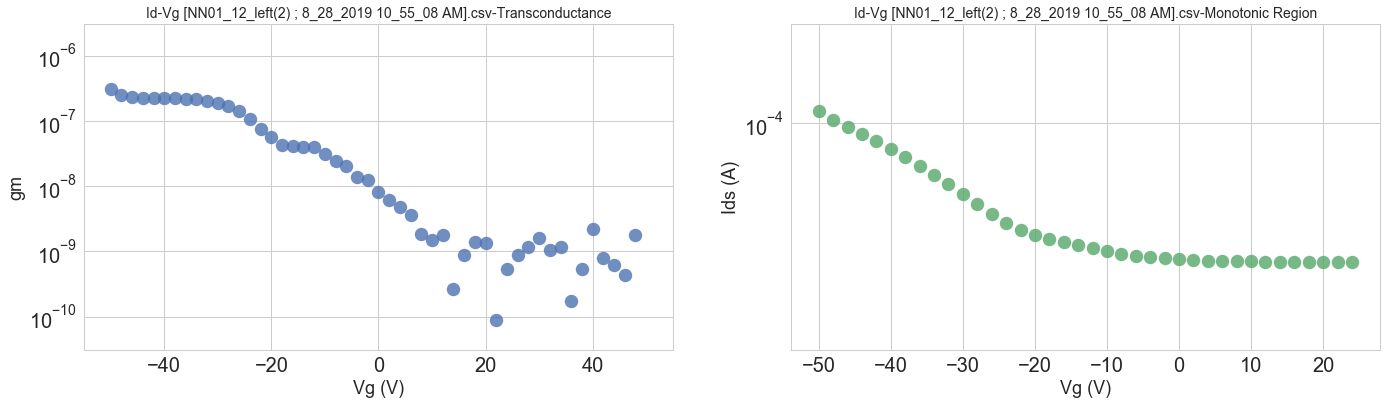

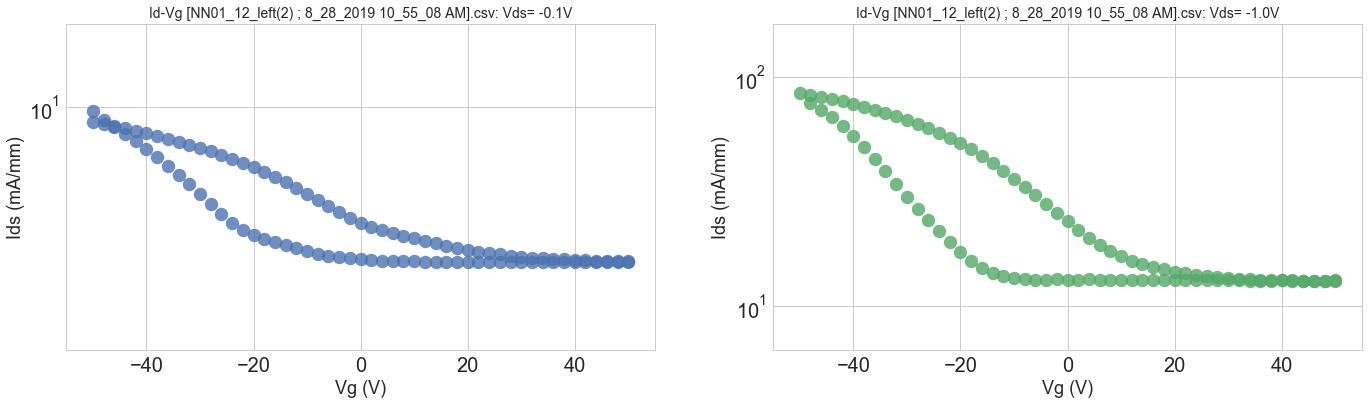

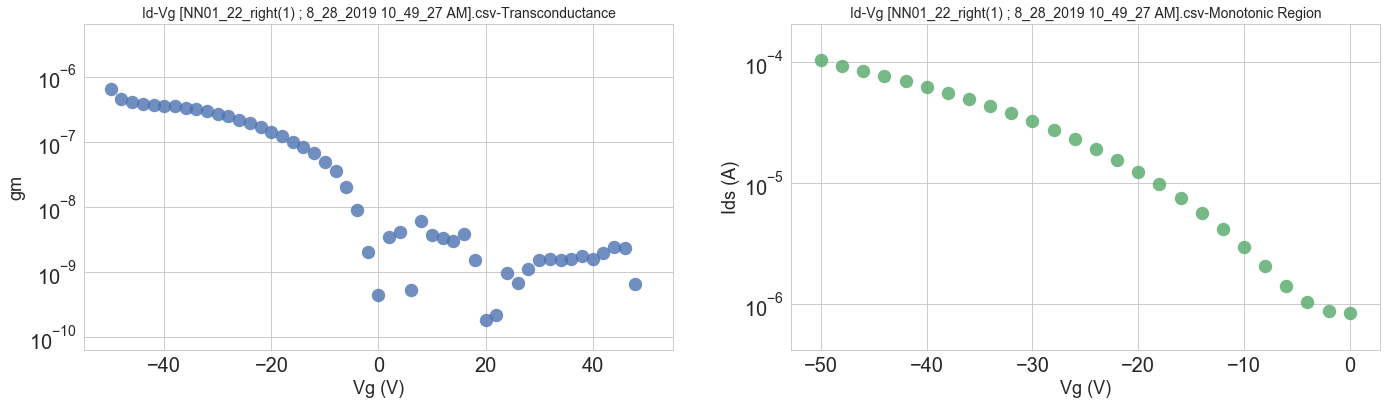

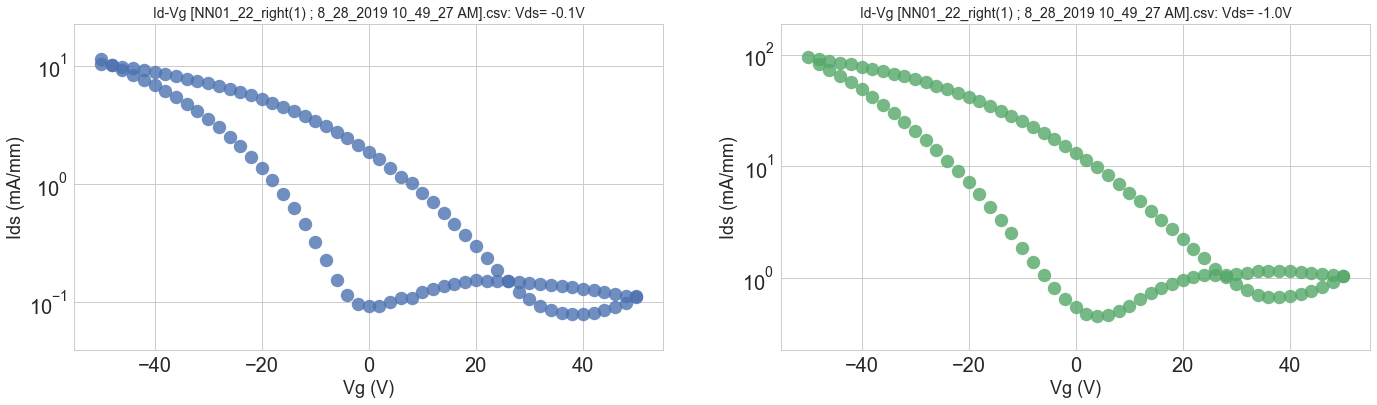

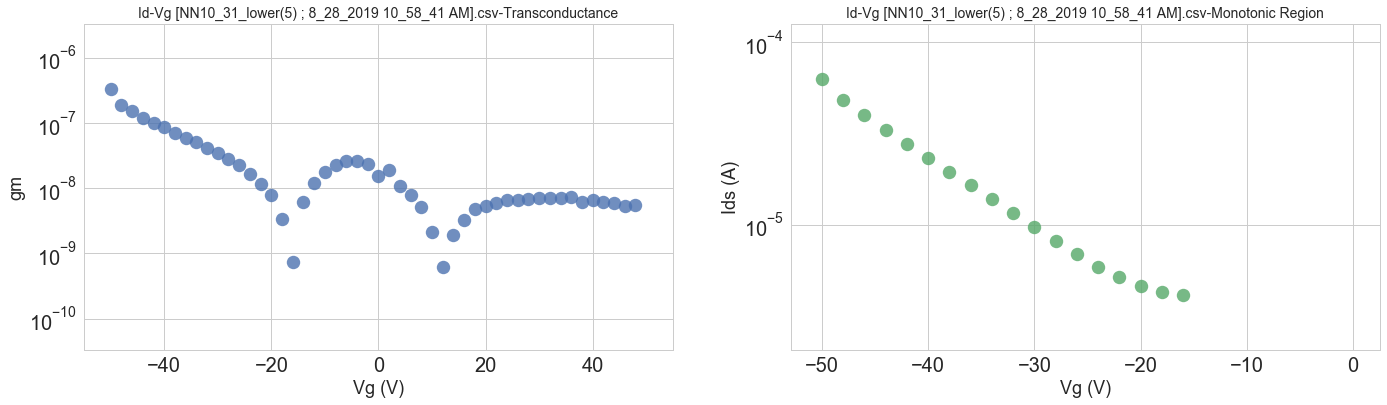

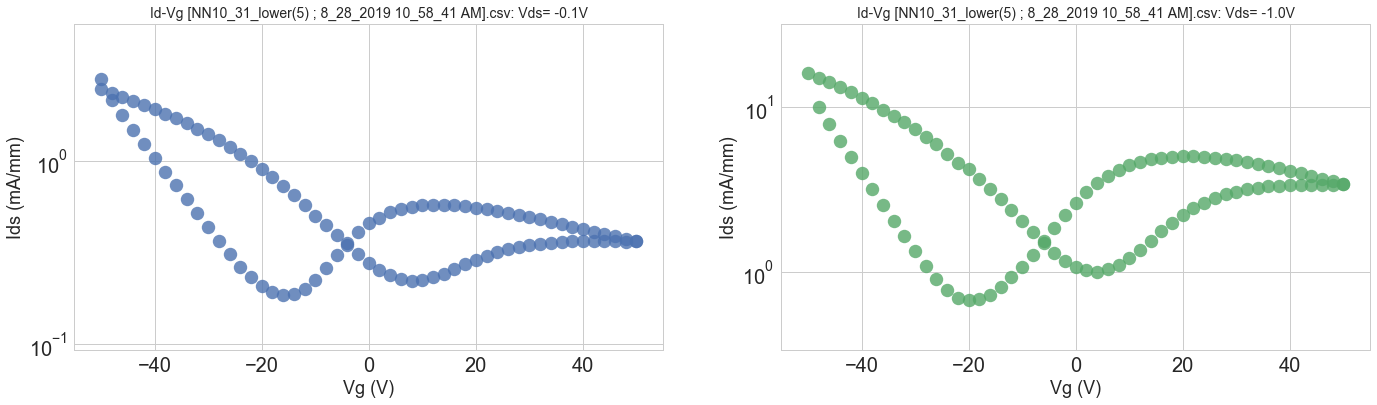

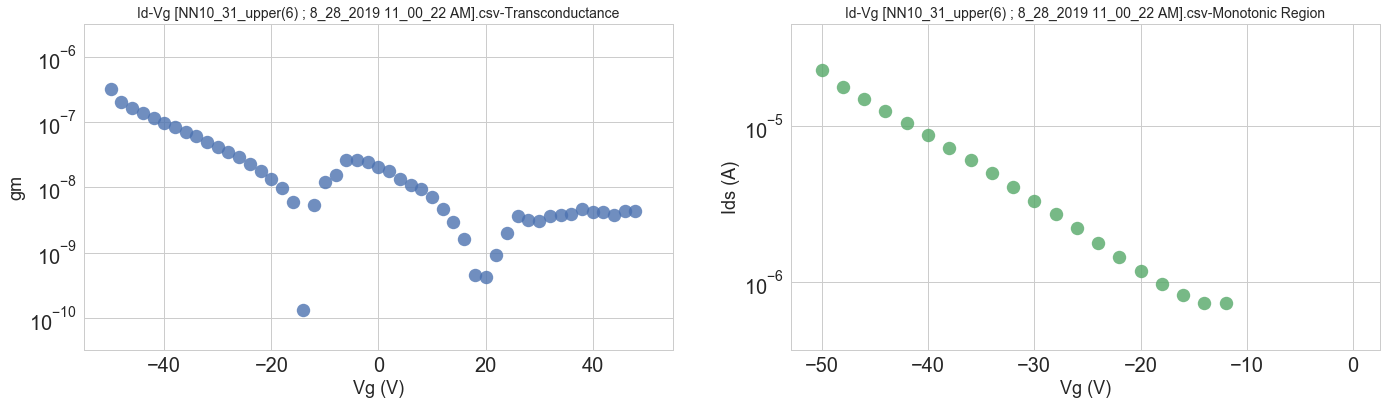

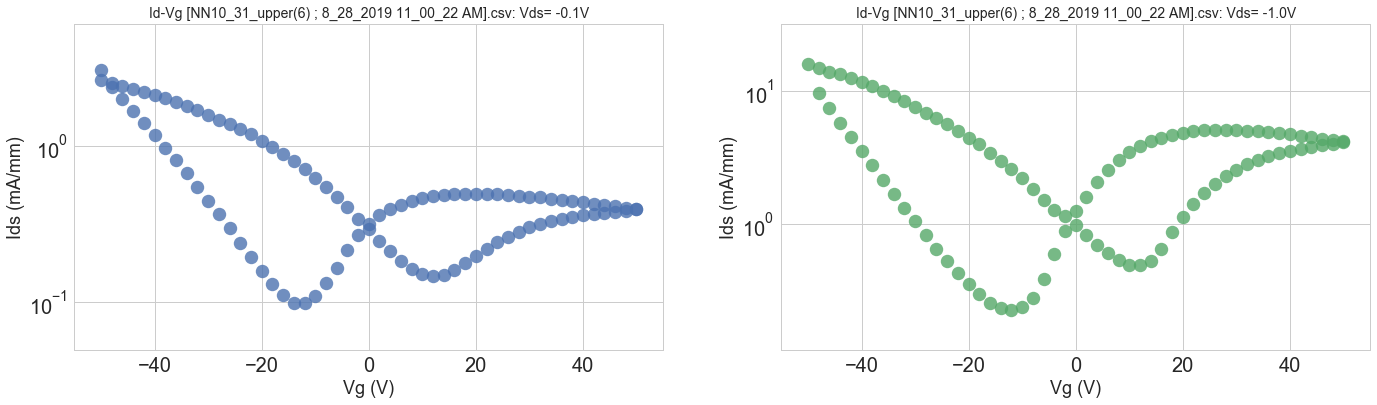

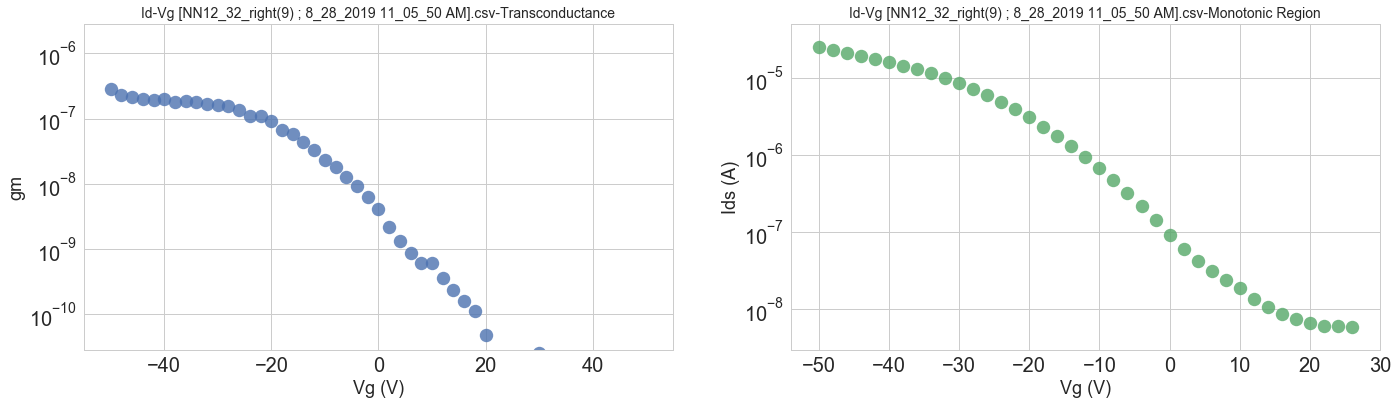

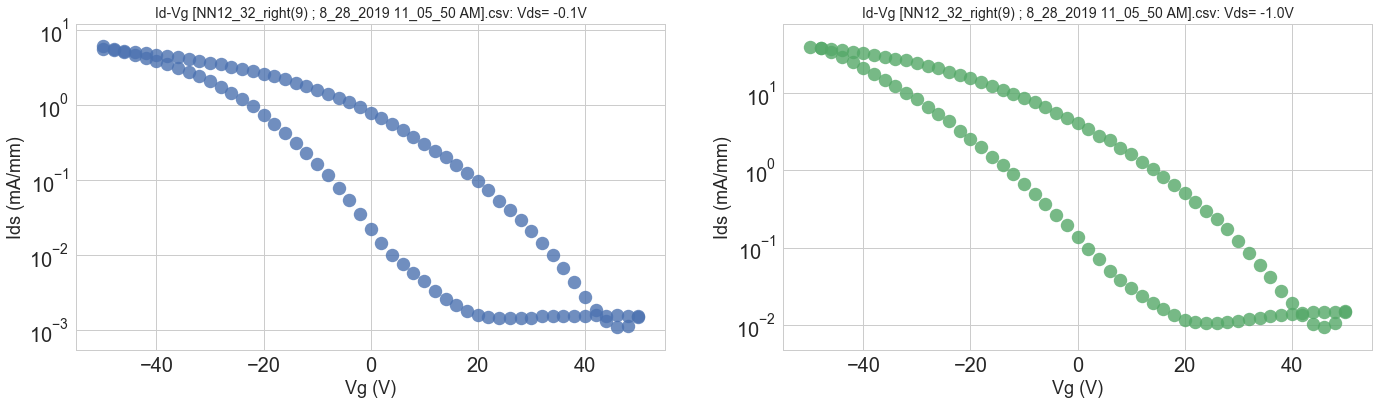

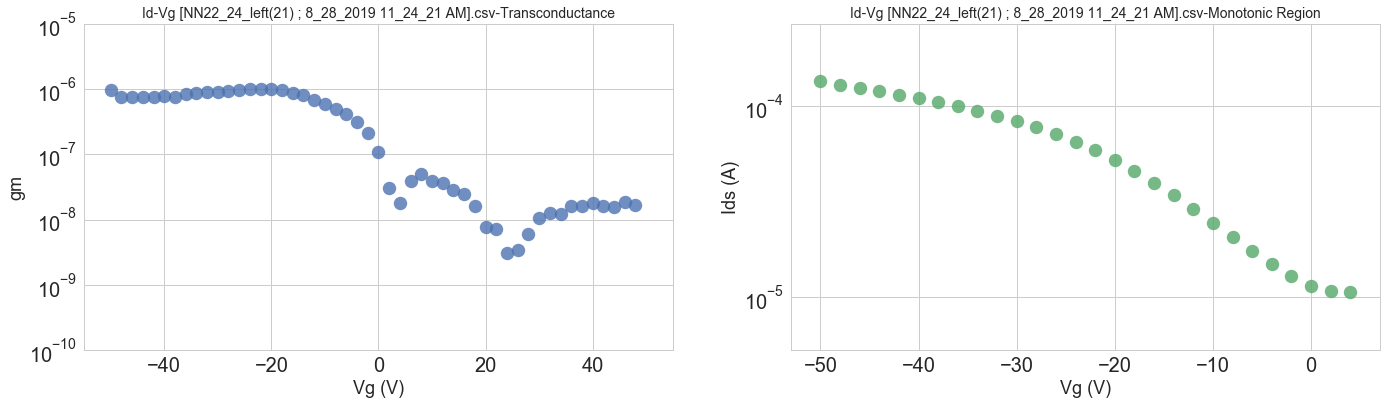

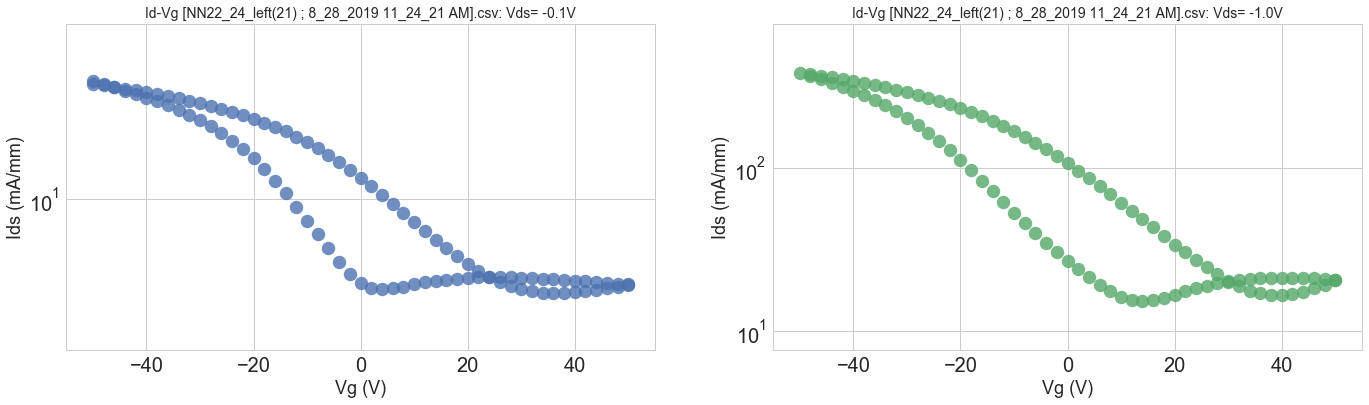

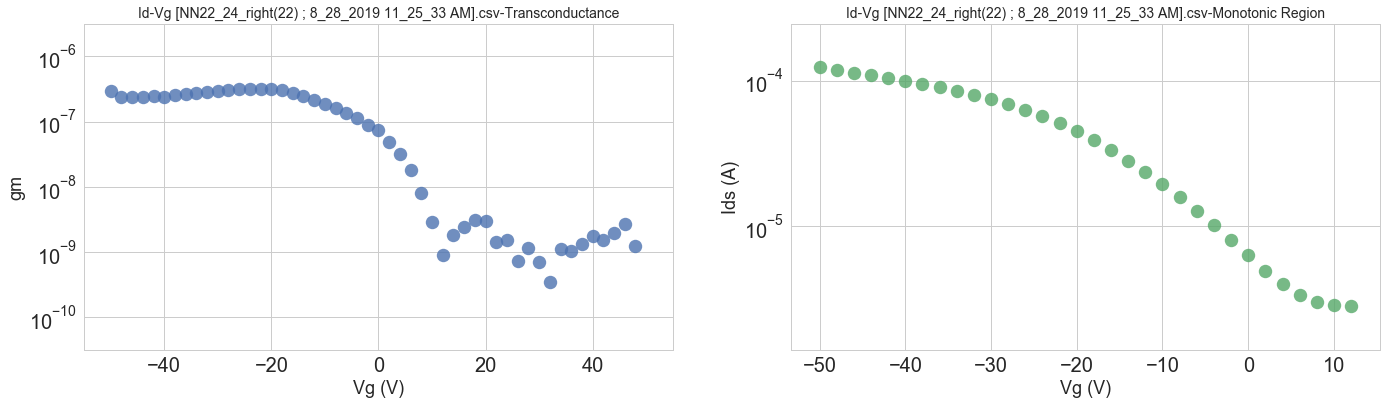

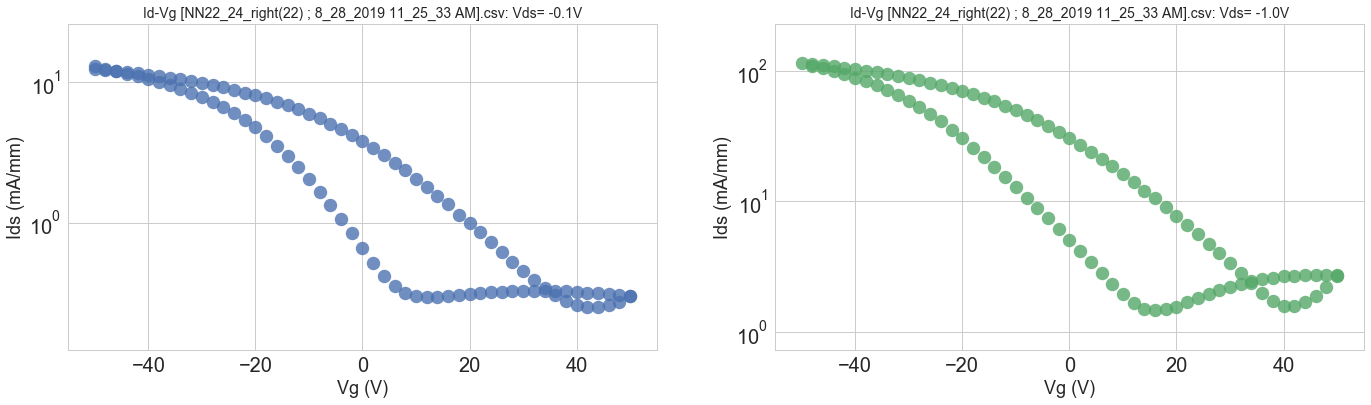

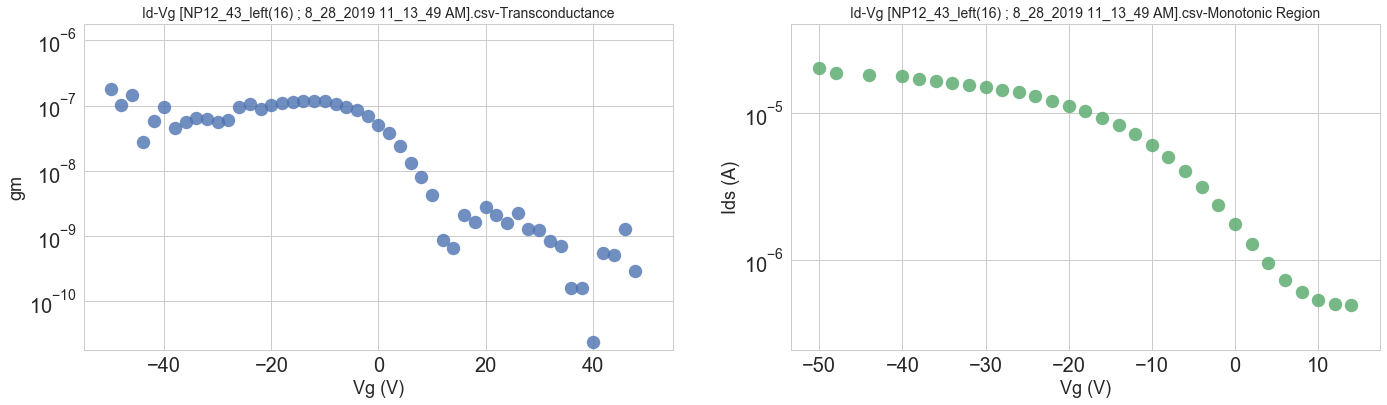

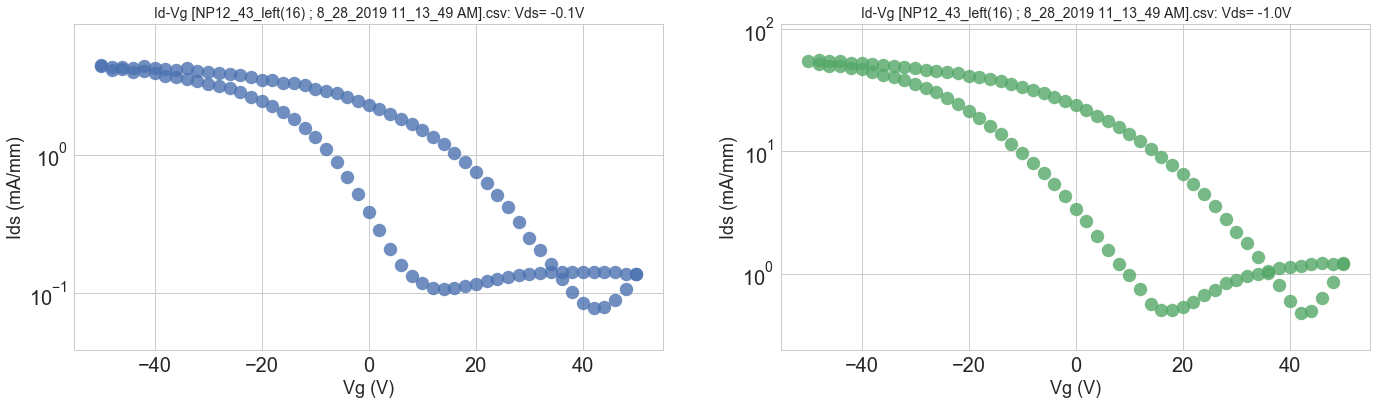

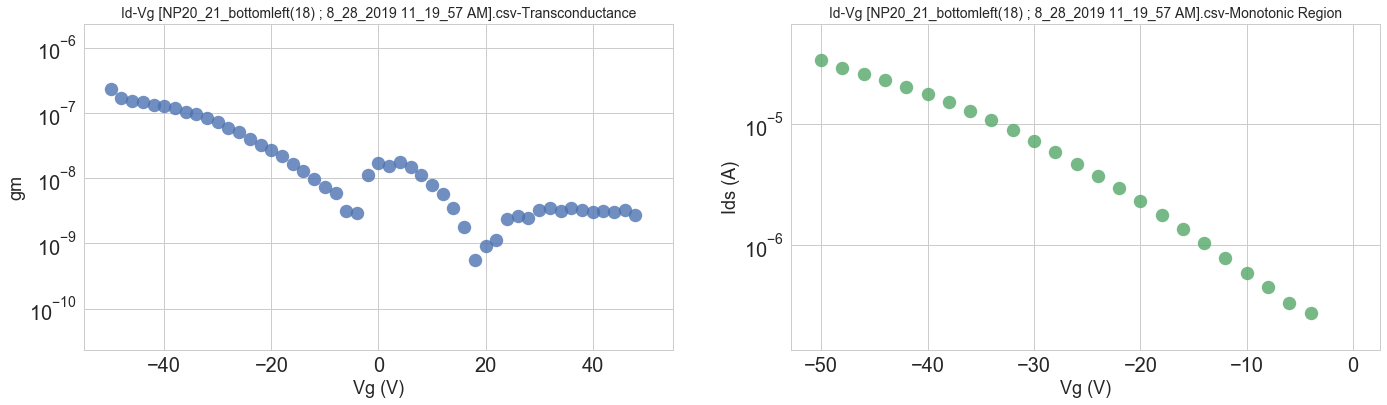

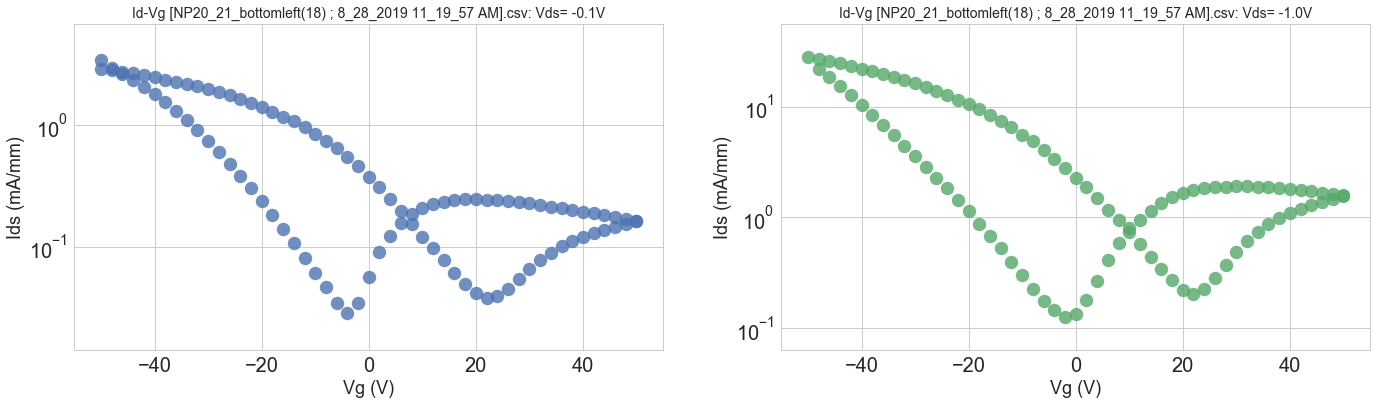

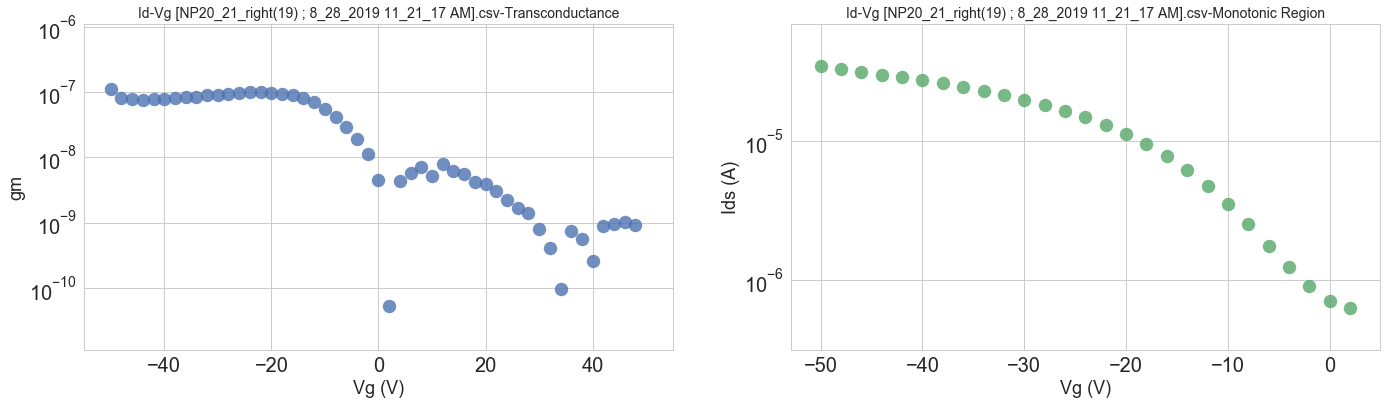

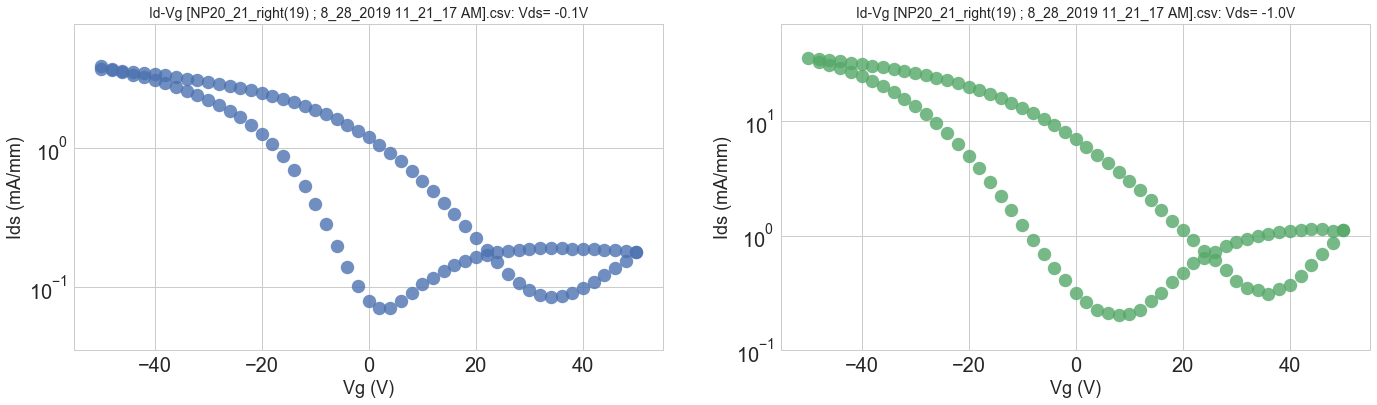

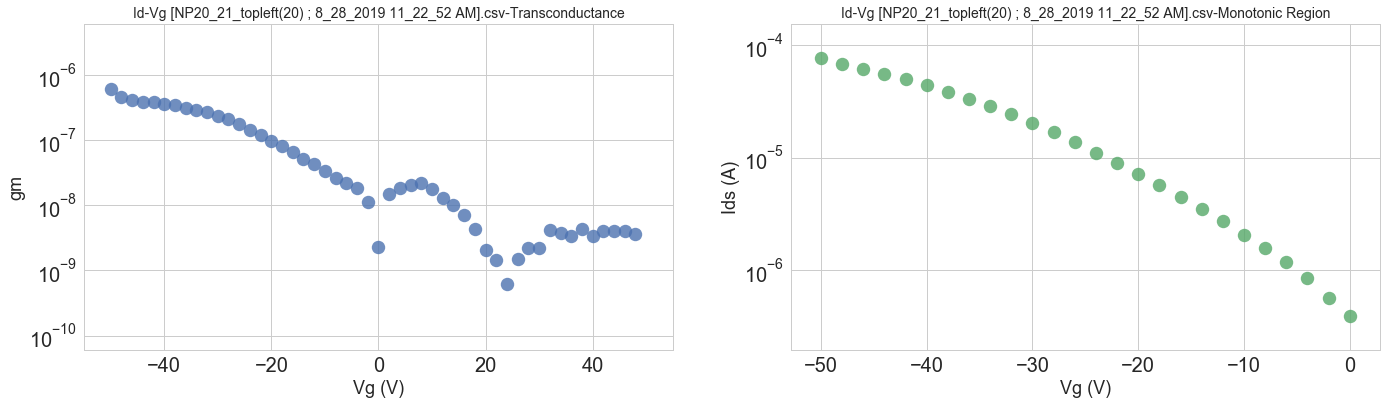

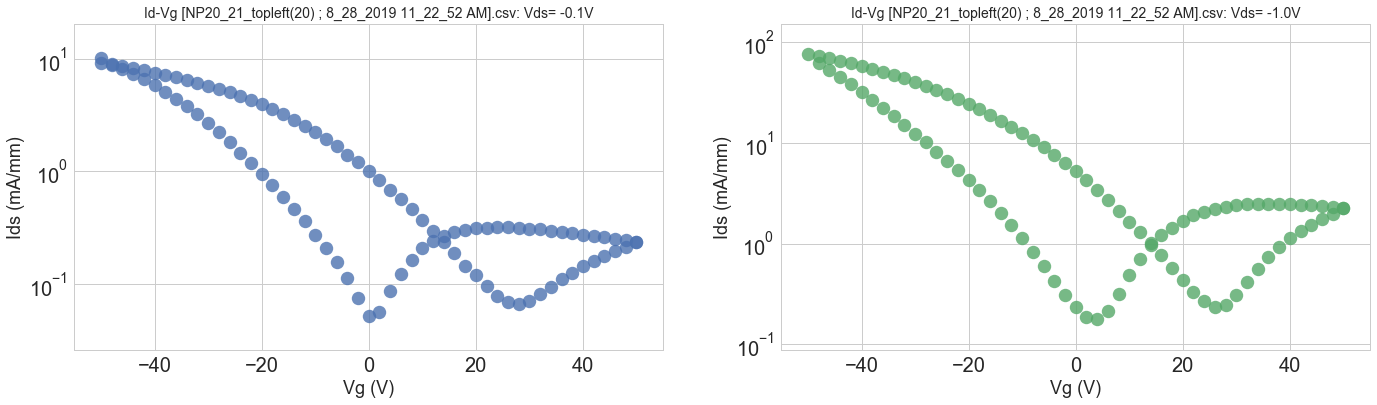

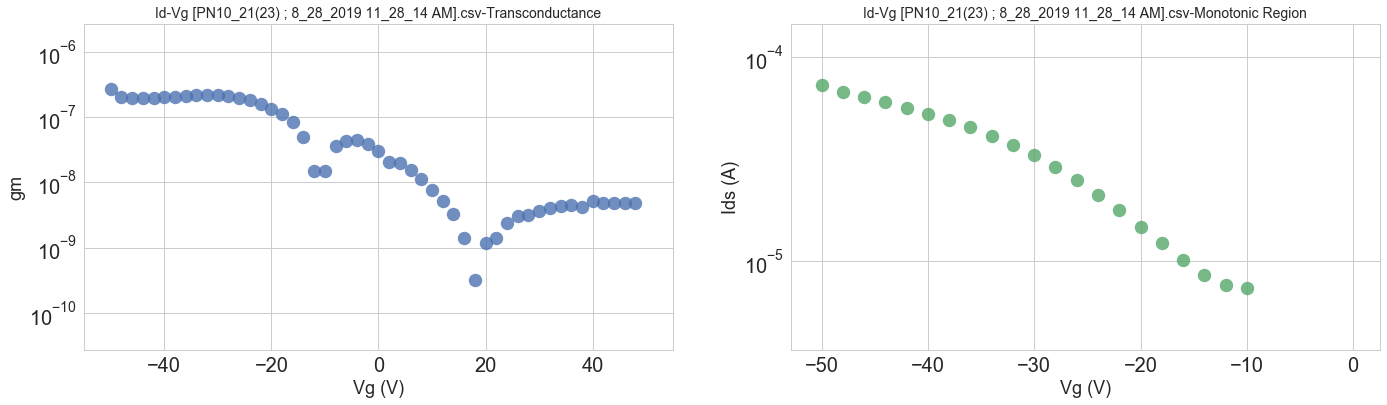

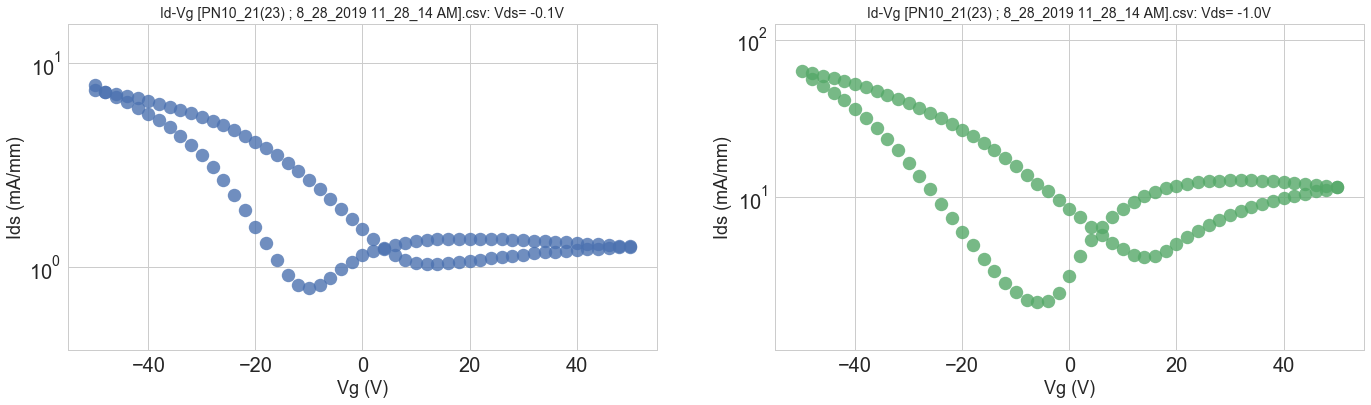

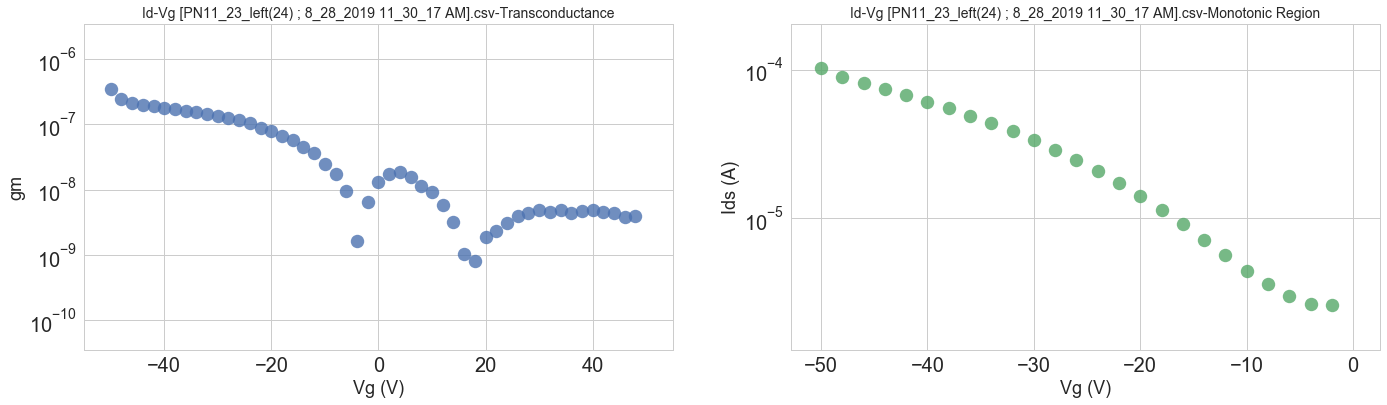

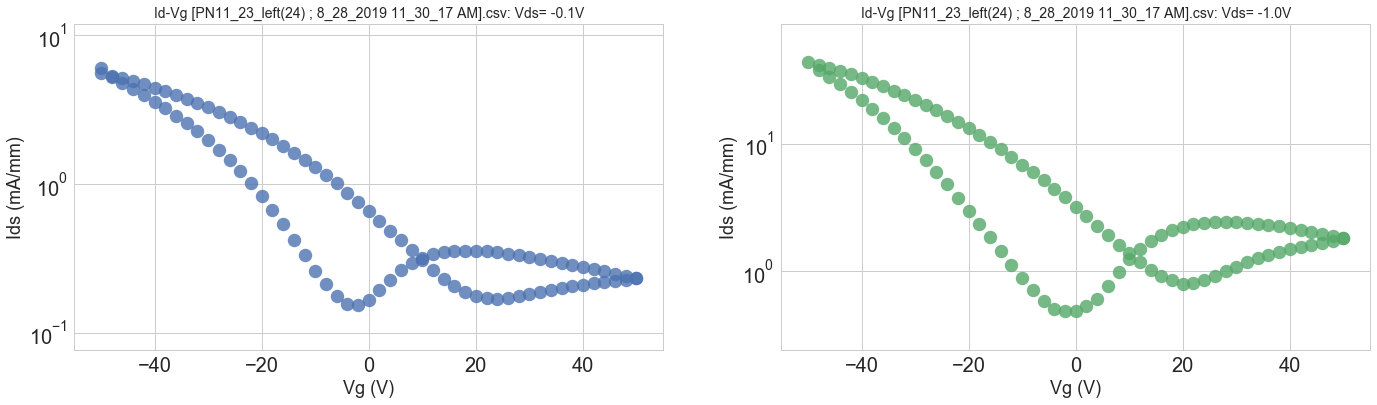

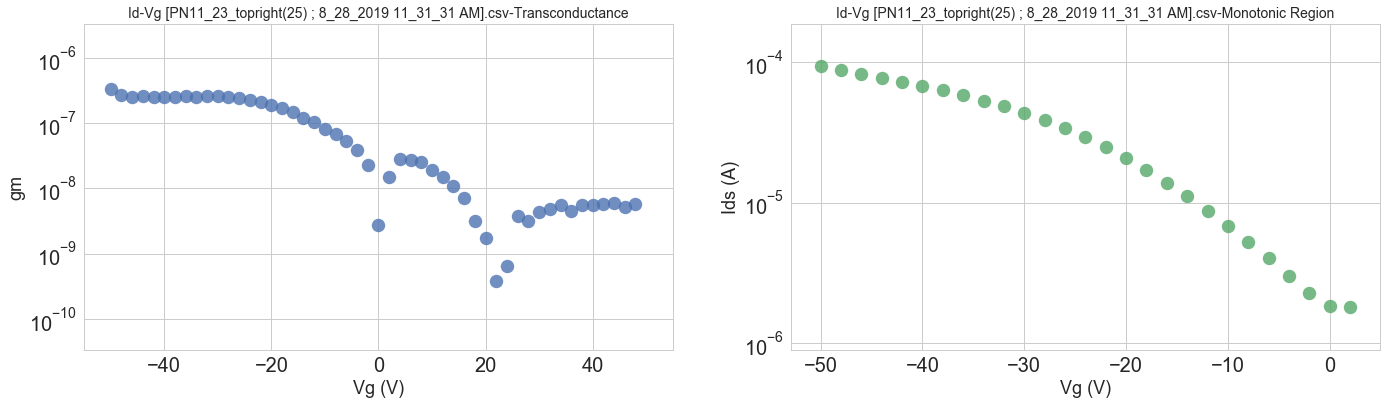

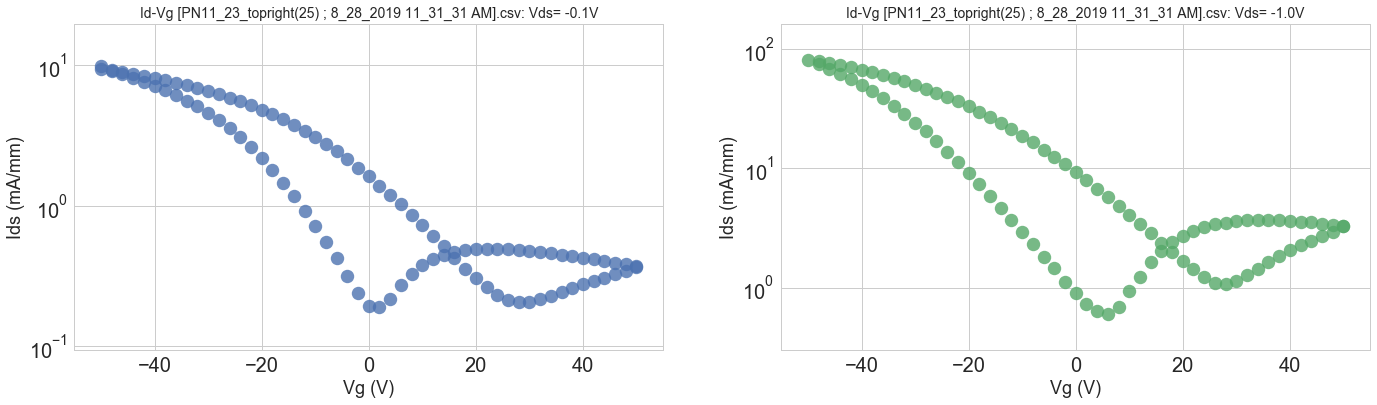

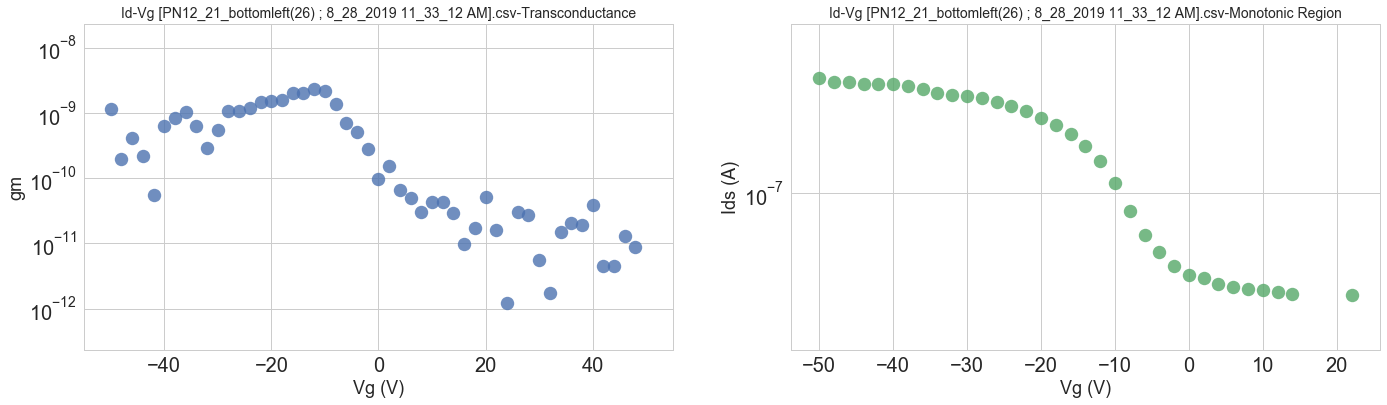

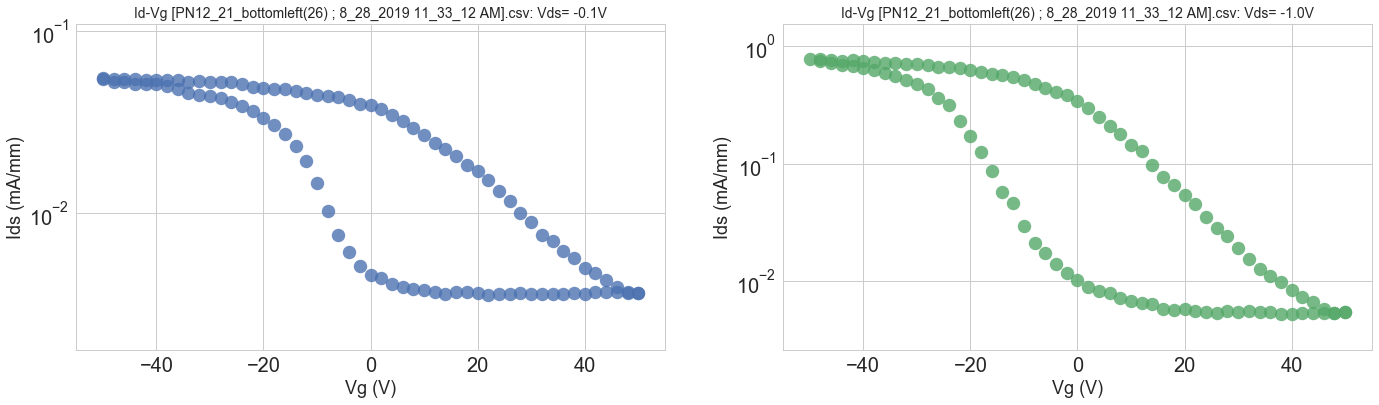

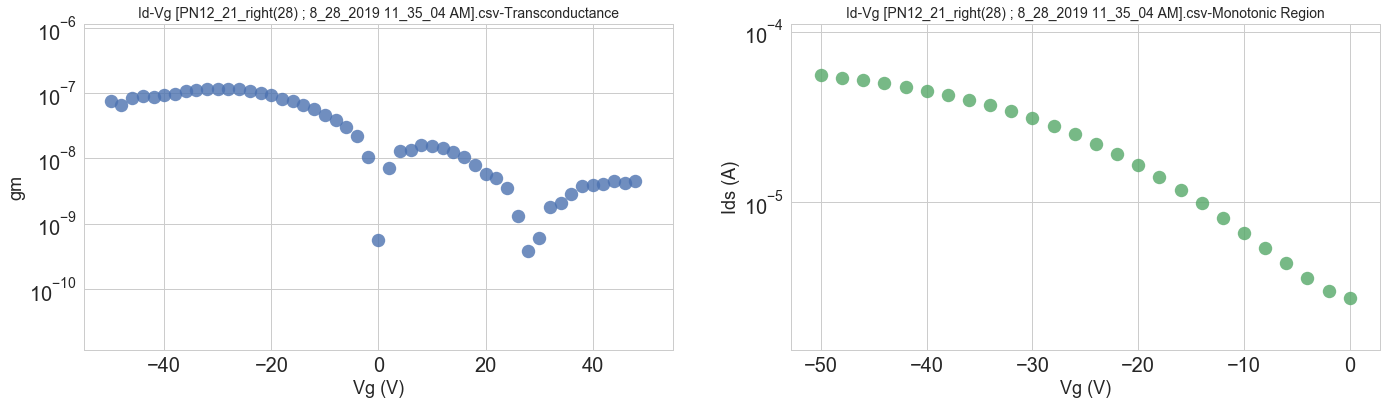

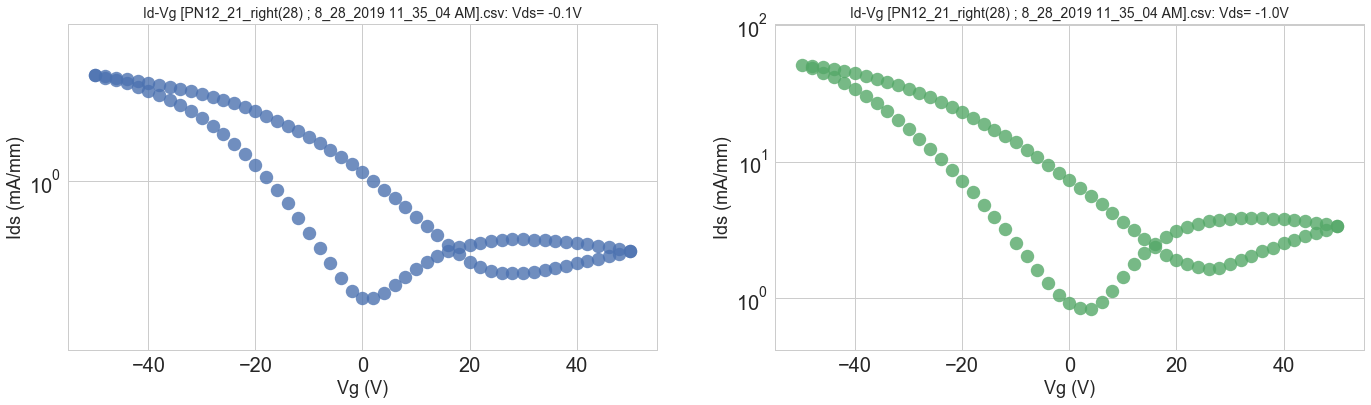

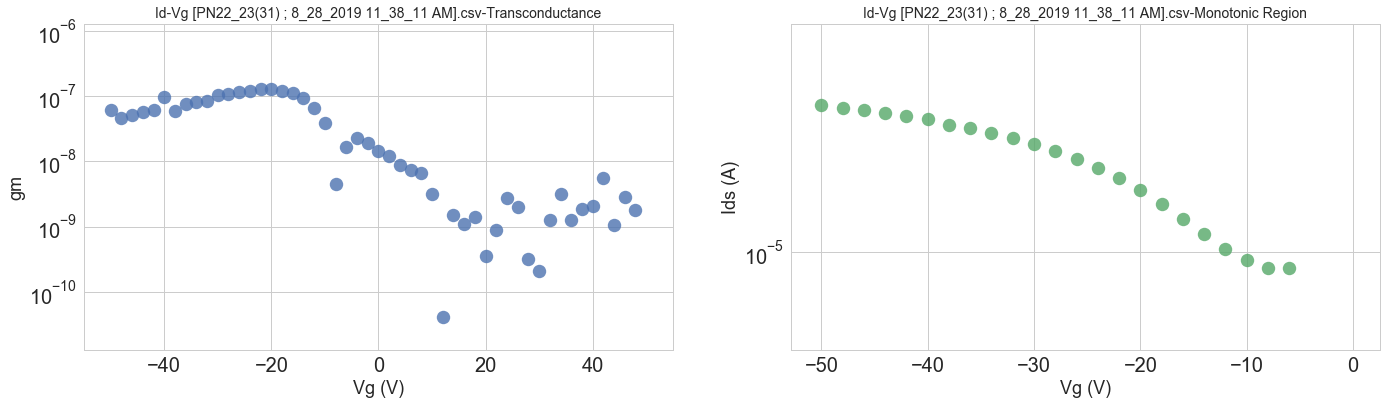

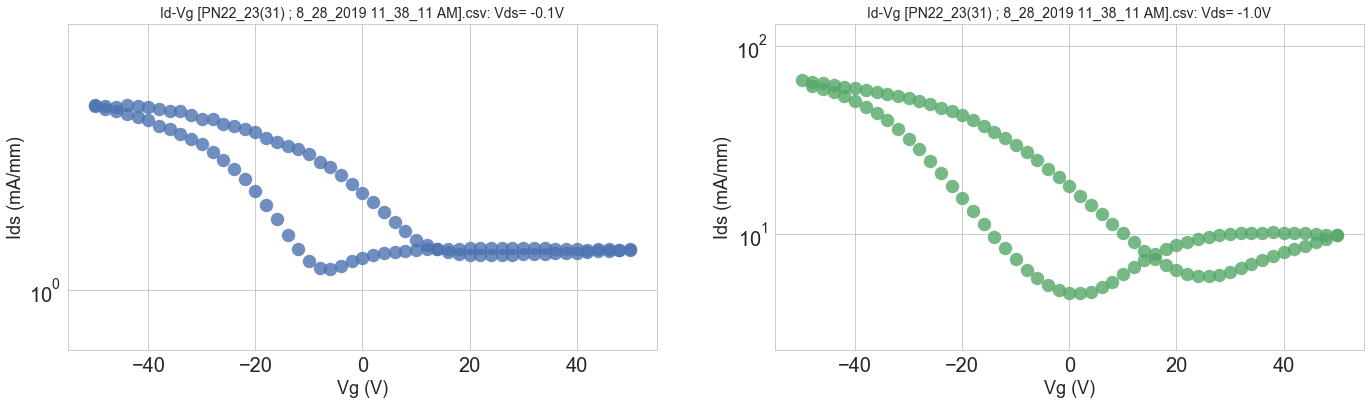

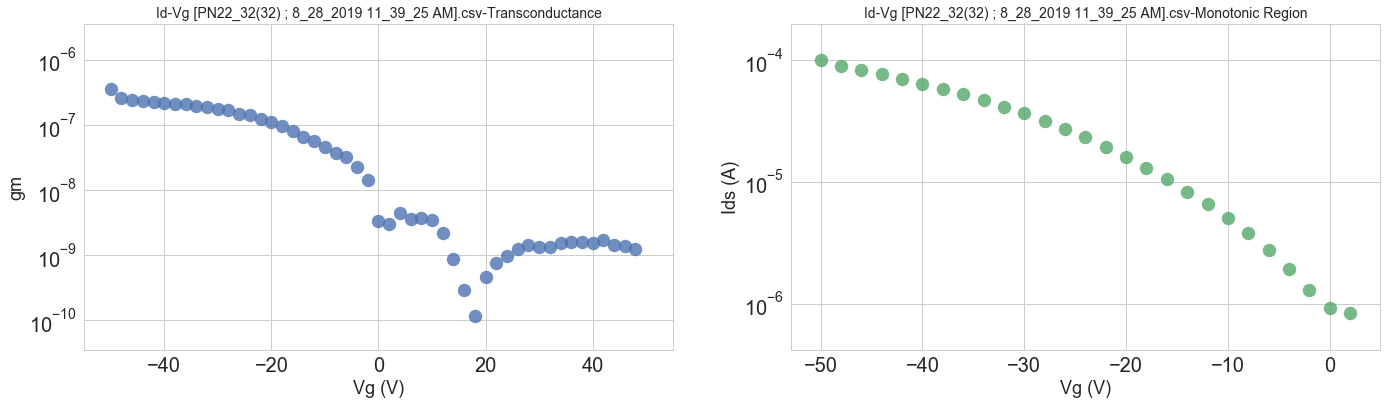

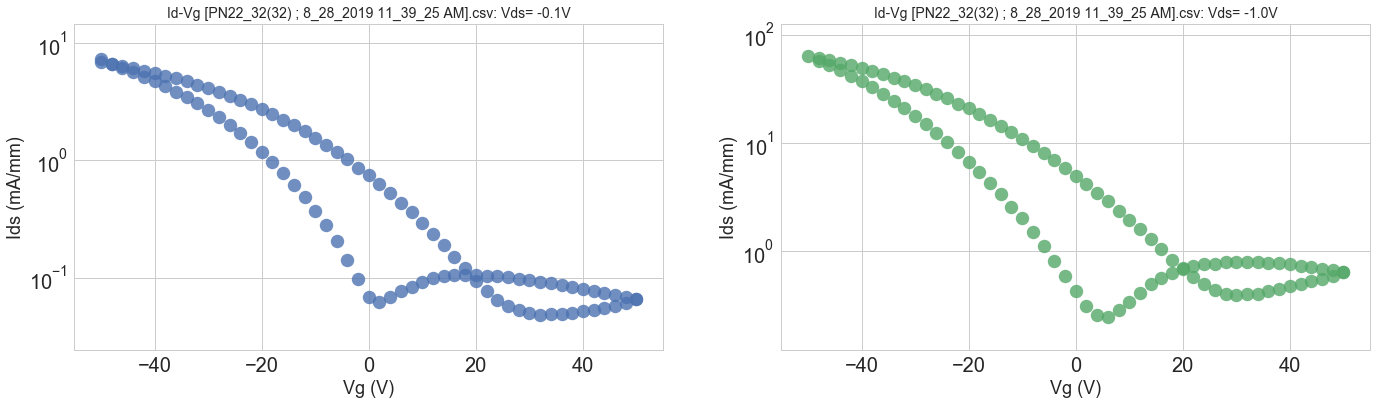

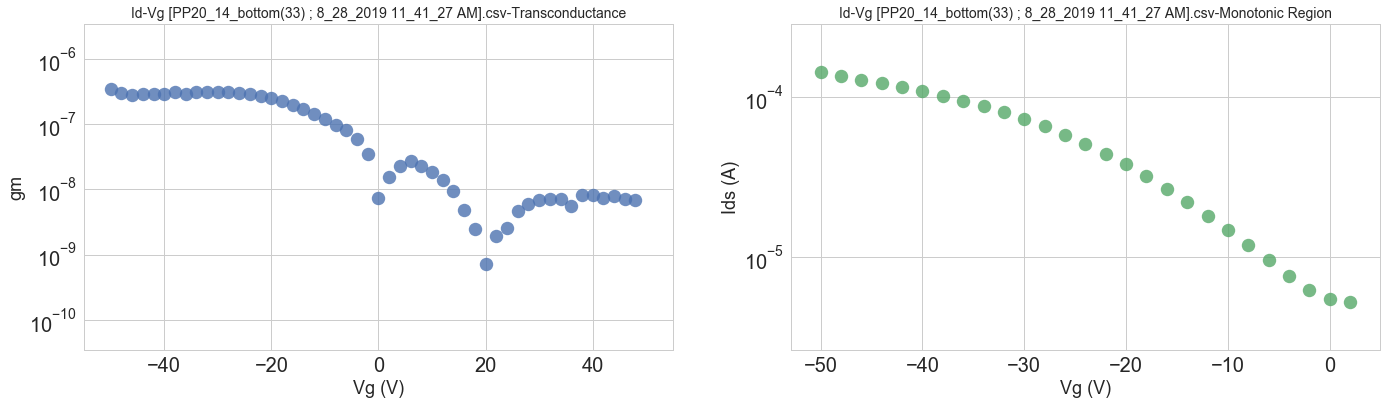

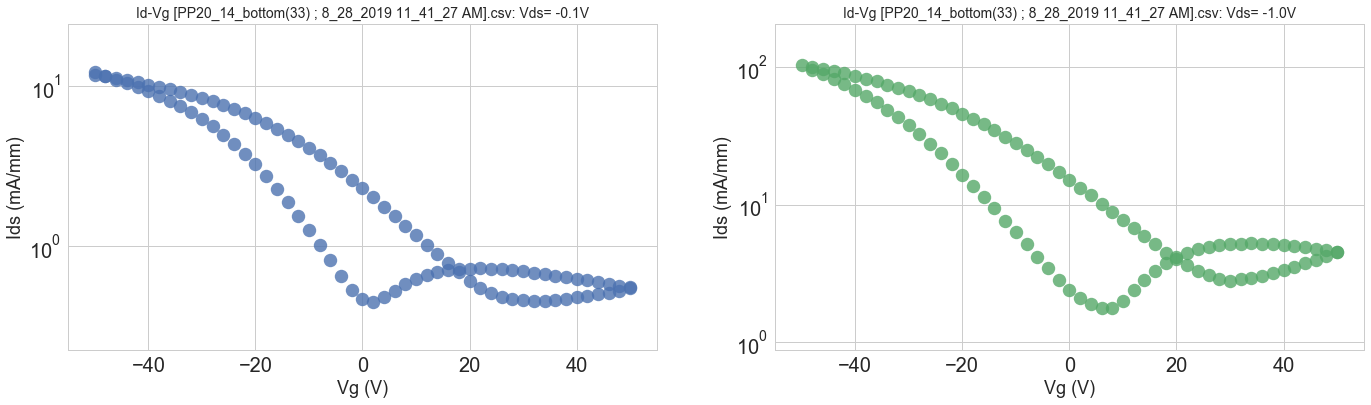

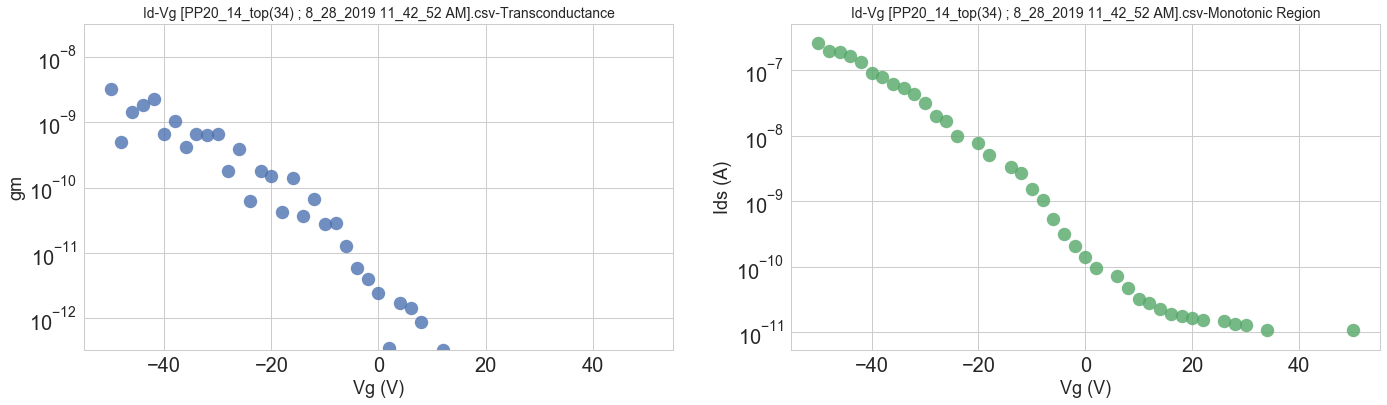

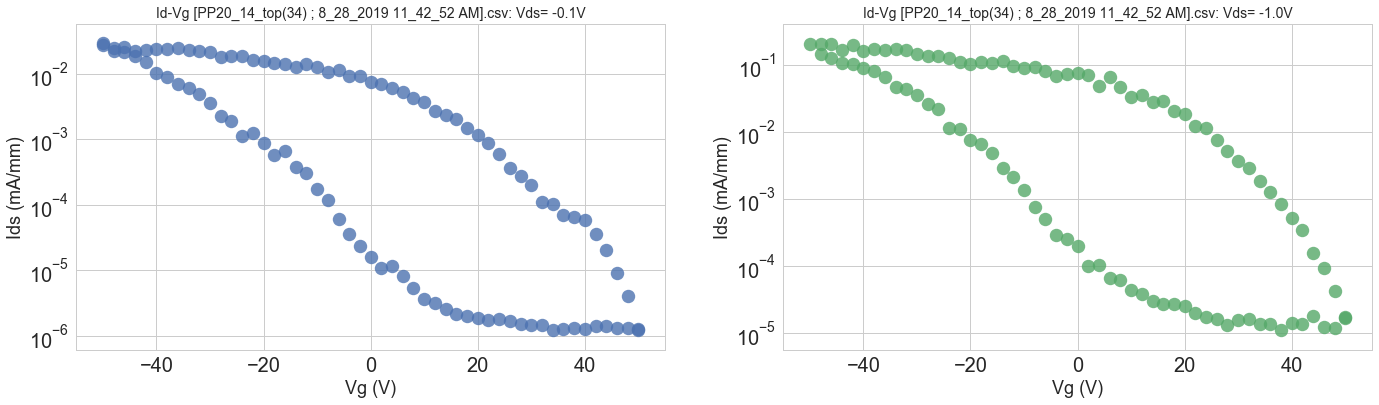

In [183]:
filepath="c:\\Users\\GSJ\\Desktop\\d1\\e1\\"
root,csv=fileReader(filepath)
result=process(root,csv,W,L,Cox,period=period,skiprows=259,chtype=chtype)

In [142]:
result

,Device Name,Mobility cm^2/vs,On-off ratio,SS mV/Decade,Vth V
0,NN01_12_left(2,322.695150,3.291862,58544.499069,-18.792023
1,NN01_22_right(,674.486826,124.064171,12287.613663,-32.459677
2,NN10_31_lower(,346.443538,15.208082,17130.176405,-41.515707
3,NN10_31_upper(,337.502259,31.151868,19436.797316,-40.519255
4,NN12_32_right(,297.228010,4248.100253,10399.772723,-28.505902
5,NN22_24_left(2,1054.608087,12.747273,27173.241272,-3.802904
6,NN22_24_right(,331.202805,43.768673,18494.624582,-5.055666
7,NP12_43_left(1,187.796220,40.999554,14973.042902,-25.478788
8,NP20_21_bottom,243.835133,123.694838,15716.059101,-35.164245
9,NP20_21_right(,117.097561,55.118533,12963.993964,-15.182453


Text(0,0.5,'Field Effect Mobility cm^2/vs')

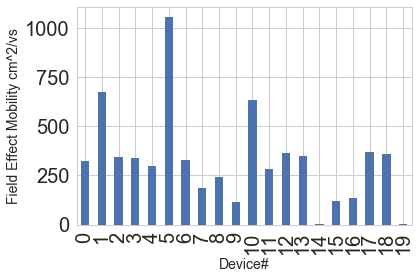

In [143]:
#plot mobility
#print(mu_df)
ax=result.iloc[:,:2].plot(kind='bar',legend=False)
ax.set_xlabel('Device#',fontsize=14)
ax.set_ylabel('Field Effect Mobility cm^2/vs',fontsize=14)

Text(0,0.5,'On-Off Ratio')

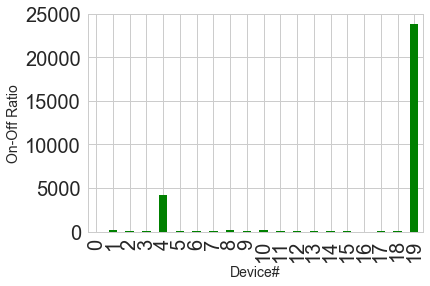

In [144]:
#plot on-off ratio
ax1=result['On-off ratio'].plot(kind='bar',color='green',legend=False)
ax1.set_xlabel('Device#',fontsize=14)
ax1.set_ylabel('On-Off Ratio',fontsize=14)

In [ ]:
name='result'
result.to_csv(r'C:\Users\GSJ\Desktop\d1\result\{}.csv'.format(name),index=False)